##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Object Detection


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/object_detection"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/object_detection.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/hub/tutorials/object_detection.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/hub/tutorials/object_detection.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/s?q=google%2Ffaster_rcnn%2Fopenimages_v4%2Finception_resnet_v2%2F1%20OR%20google%2Ffaster_rcnn%2Fopenimages_v4%2Finception_resnet_v2%2F1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

This Colab demonstrates use of a TF-Hub module trained to perform object detection.

## Setup


In [2]:
#@title Imports and function definitions

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2024-03-01 23:47:30.247163: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-01 23:47:30.490200: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-01 23:47:30.491213: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-01 23:47:31.881212: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.1
The following GPU devices are available: 


/home/todin/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2024-03-01 23:47:34.094529: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 23:47:34.095909: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu 

## Example use

### Helper functions for downloading images and for visualization.

Visualization code adapted from [TF object detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py) for the simplest required functionality.

In [25]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.LANCZOS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    bbox = font.getbbox(display_str)
    text_width, text_height = bbox[2], bbox[3]
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin
  
def draw_boxes(image, boxes, class_info):
    """Draw bounding boxes on the image."""
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
    
    for i in range (boxes.shape[0]):
        ymin, xmin, ymax, xmax = boxes[i]
        color = colors[hash(class_info[i]) % len(colors)]

        # Draw bounding box on the image
        draw_bounding_box_on_image(
            image_pil,
            ymin,
            xmin,
            ymax,
            xmax,
            color,
            font,
            display_str_list=[f'Class: {class_info[i]}'],
        )
        np.copyto(image, np.array(image_pil))

    return image


## Apply module

Load a public image from Open Images v4, save locally, and display.

Image downloaded to /tmp/tmpznivrvxm.jpg.


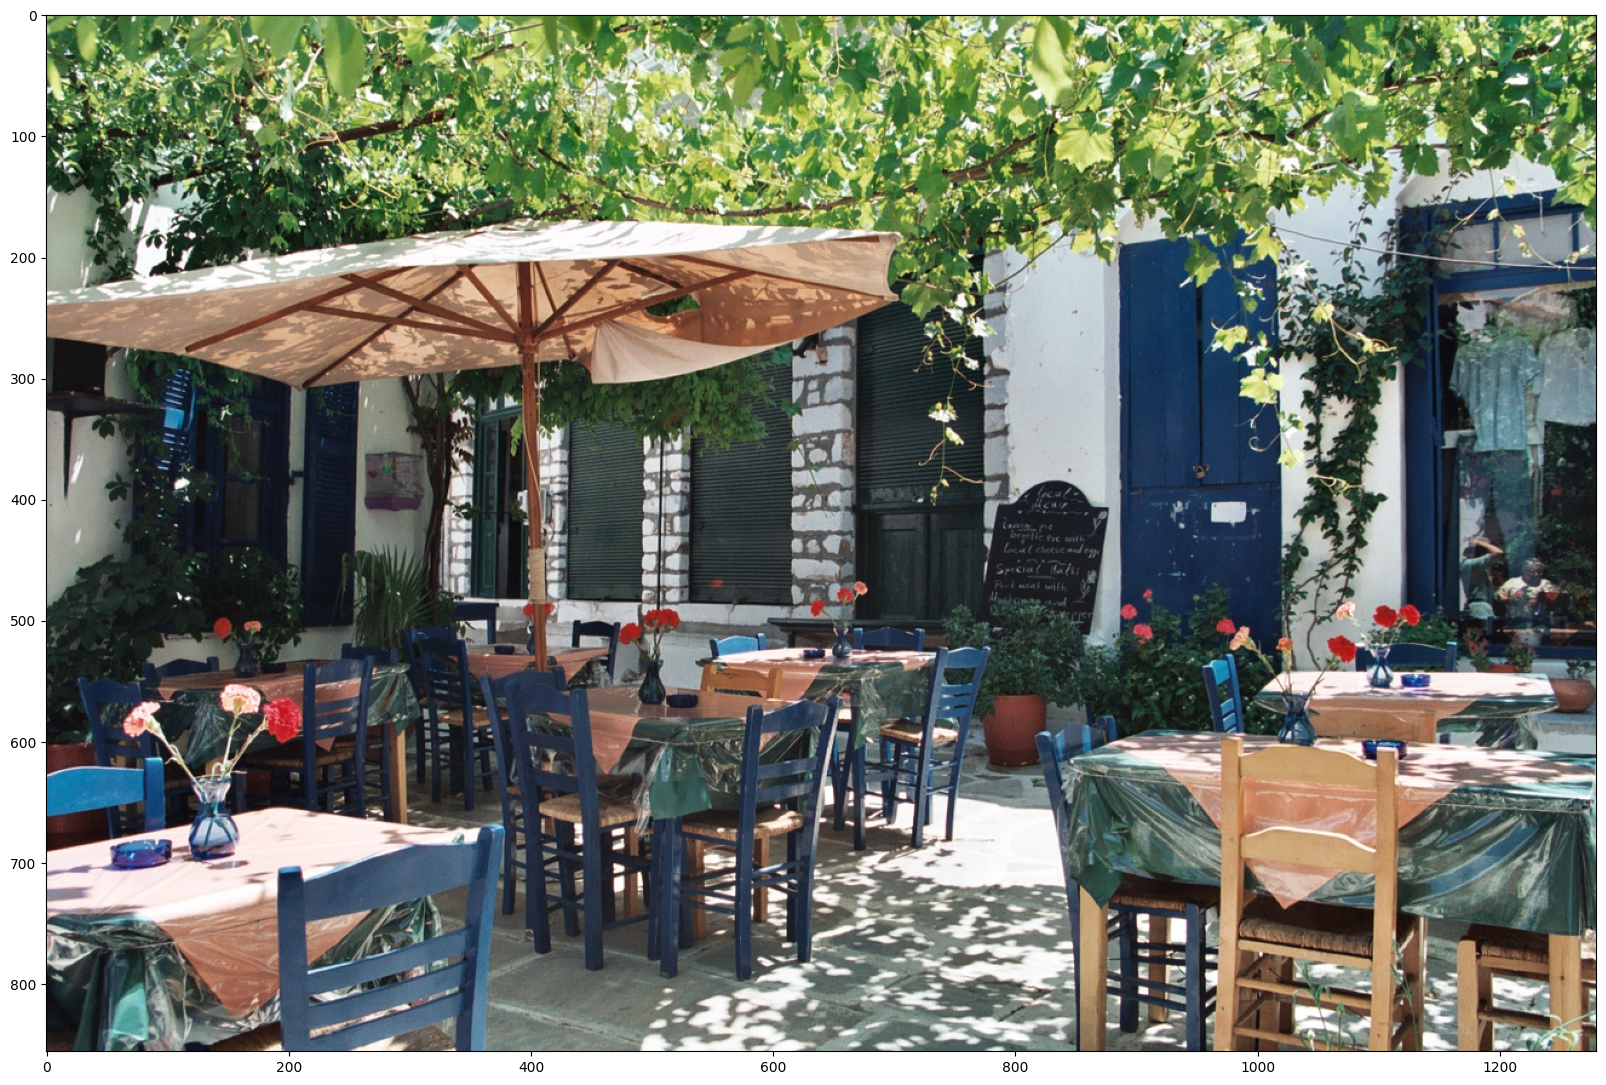

In [4]:
# By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
image_url = "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg"  #@param
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

Pick an object detection module and apply on the downloaded image. Modules:
* **FasterRCNN+InceptionResNet V2**: high accuracy,
* **ssd+mobilenet V2**: small and fast.

In [5]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
2024-03-01 23:47:47.737069: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 23:47:47.737241: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [7]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

In [8]:
run_detector(detector, downloaded_image_path)

2024-03-01 23:48:36.334774: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -2484 } dim { size: -2485 } dim { size: -2486 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -105 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -105 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 17 } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2499 num_cores: 8 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 8388608 memory_size: 268435456 } outputs { dtype: DT_FLOAT 

Found 100 objects.
Inference time:  37.87882471084595


TypeError: draw_boxes() takes 3 positional arguments but 4 were given

### More images
Perform inference on some additional images with time tracking.


In [10]:
image_urls = [
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  "https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg",
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg",
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  "https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg",
  ]

def detect_img(image_url):
  start_time = time.time()
  image_path = download_and_resize_image(image_url, 640, 480)
  run_detector(detector, image_path)
  end_time = time.time()
  print("Inference time:",end_time-start_time)

In [11]:
detect_img(image_urls[0])

Image downloaded to /tmp/tmp5dj4z46m.jpg.
Found 100 objects.
Inference time:  7.450566530227661


TypeError: draw_boxes() takes 3 positional arguments but 4 were given

In [9]:
detect_img(image_urls[1])

NameError: name 'detect_img' is not defined

Image downloaded to /tmp/tmprb6f4xg8.jpg.
Found 100 objects.
Inference time:  13.395416736602783
Inference time: 13.676191806793213


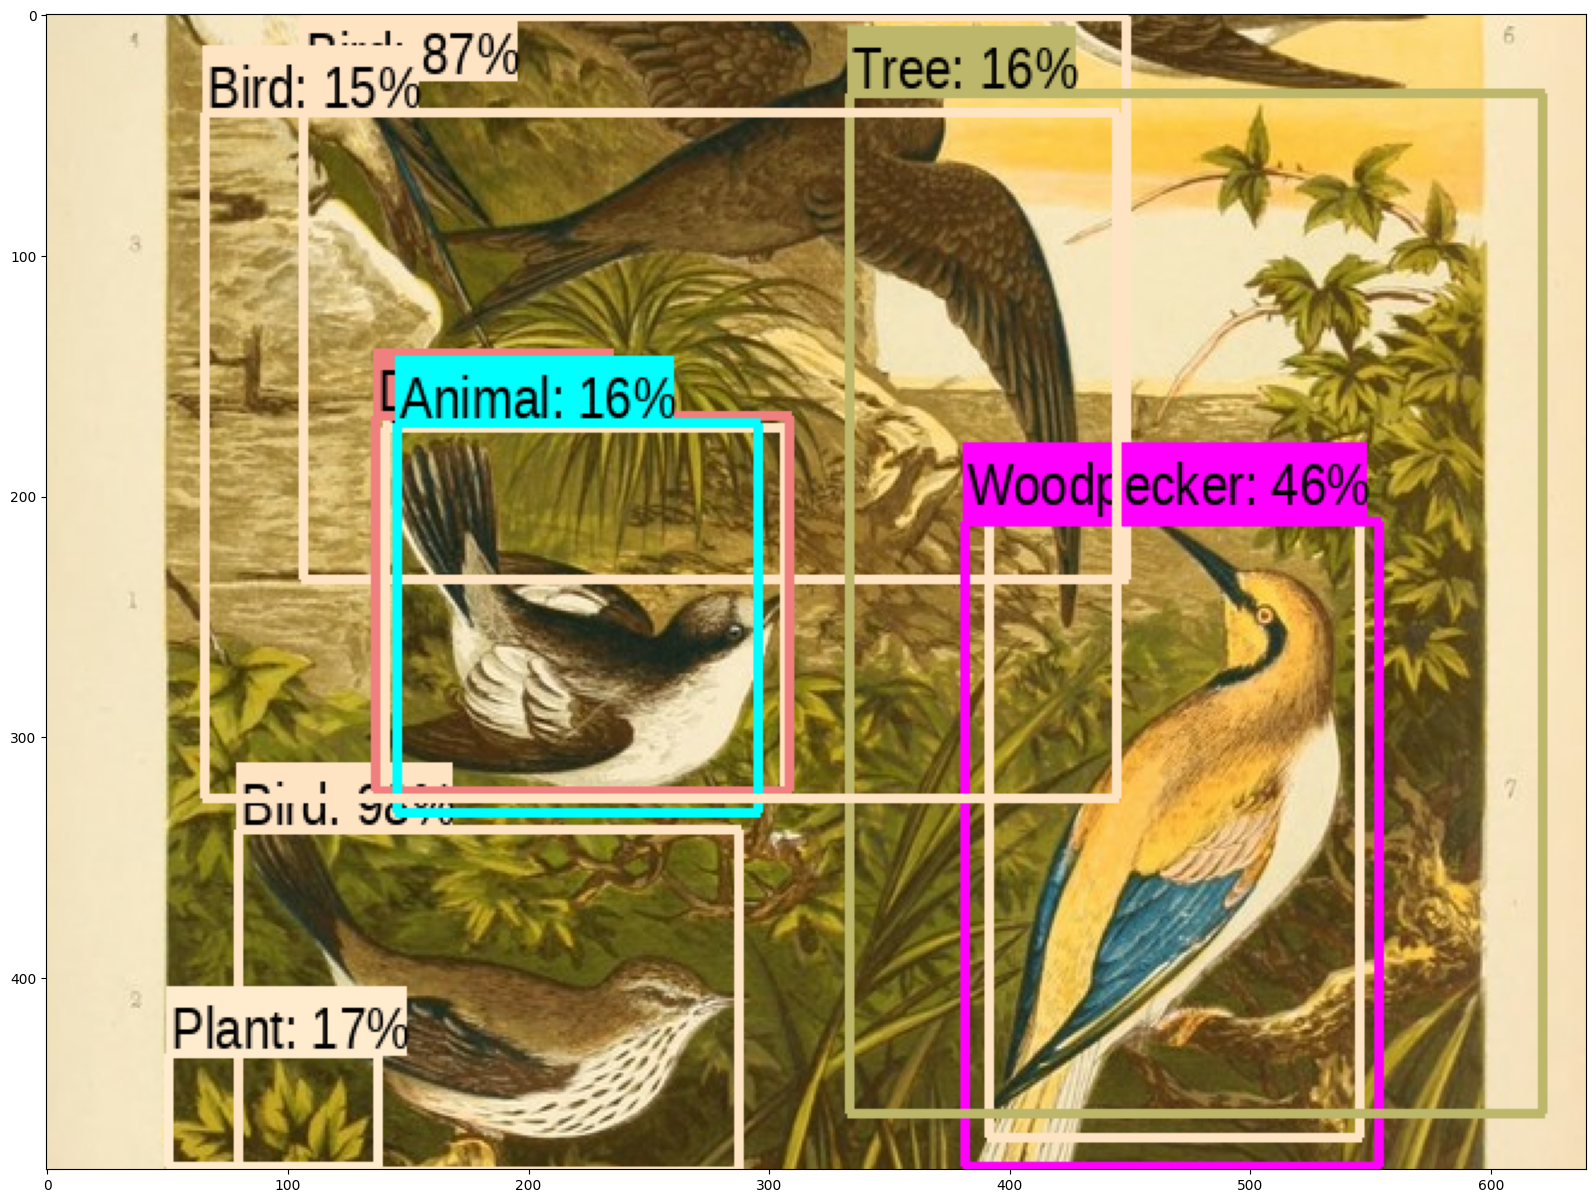

In [ ]:
detect_img(image_urls[2])

In [12]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications import MobileNetV2

In [13]:
def read_and_crop(path):
    
    # Read the CSV file into a DataFrame
    if path[-1] == '/':
        df = pd.read_csv(path +'_annotations.csv')
    else :
        df = pd.read_csv(path +'/_annotations.csv')

    # Read and store cropped images
    cropped_image_list = []

    for index, row in df.iterrows():
        image_path = row['filename']
        if path[-1] == '/':
            image = Image.open(path + image_path)
        else :
            image = Image.open(path + '/' + image_path)
            

        # Extract cropping coordinates
        xmin, ymin, xmax, ymax = (
            max(0, row['xmin']),
            max(0, row['ymin']),
            min(image.width, row['xmax']),
            min(image.height, row['ymax'])
        )

        # Check if the adjusted coordinates are valid
        if xmin < xmax and ymin < ymax:
            
            # Crop the image
            cropped_image = np.array(image.crop((xmin, ymin, xmax, ymax))) 

            # Reshape the images in the 'cropped_image' column
            cropped_reshape_image = cv2.resize(cropped_image, (171, 138))

            # Store the cropped image in the list
            cropped_image_list.append(cropped_reshape_image)
        else:
            # If the coordinates are invalid, append a placeholder (e.g., None)
            cropped_image_list.append(None)

    # Add a new column to the DataFrame with cropped images
    df['cropped_image'] = cropped_image_list.copy()

    # Filter out rows with None values in the 'cropped_image' column
    df_valid_crops = df.dropna(subset=['cropped_image']).copy()
    
    df_final = df_valid_crops[['class', 'cropped_image']].copy()
    
    # 
    old_class_to_actual_class = {
        'tuna' : 'tuna', 
        'surgeon': 'surgeon', 
        'shark': 'shark', 
        'jack': 'jack', 
        'grouper': 'grouper', 
        'parrot': 'parrot', 
        'snapper': 'snapper',
        'damsel': 'damsel', 
        'trigger': 'trigger', 
        'Zanclidae (Moorish Idol)': 'moorish idol',
        'Scaridae -Parrotfishes-': 'parrot', 
        'Carangidae -Jacks-': 'jack',
        'Scombridae -Tunas-': 'tuna', 
        'Shark -Selachimorpha-': 'shark',
        'Serranidae -Groupers-': 'grouper', 
        'Lutjanidae -Snappers-': 'snapper',
        'Acanthuridae -Surgeonfishes-': 'surgeon', 
        'Pomacentridae -Damselfishes-': 'damsel',
        'Labridae -Wrasse-': 'wrasse', 
        'angel': 'angel', 
        'wrasse': 'wrasse', 
        'Zanclidae -Moorish Idol-': 'moorish idol',
        'Ephippidae -Spadefishes-': 'spade', 
        'Pomacanthidae -Angelfishes-': 'angel',
        'Balistidae -Triggerfishes-': 'trigger', 
        'spade': 'spade'
    }
   
    # Replace old class names with new class names
    df_final['class'] = df_final['class'].replace(old_class_to_actual_class)
    
    return df_final


def print_image_by_classes(df,images_to_plot=2):
    
    # Get unique classes in the DataFrame
    unique_classes = df['class'].unique()

    # Plot two random images for each class
    for class_name in unique_classes:
        # Filter DataFrame based on the current class
        df_same_class = df[df['class'] == class_name]

        # Check the number of images in the current class
        num_images = len(df_same_class)

        if num_images >= images_to_plot:
            # Randomly select two images from the current class
            random_indices = random.sample(df_same_class.index.tolist(), images_to_plot)

            # Plot the two random images for the current class
            fig, axes = plt.subplots(1, images_to_plot, figsize=(10, 5))
            fig.suptitle(f'Two Random Images of Class: {class_name}')

            for i, ax in enumerate(axes):
                ax.imshow(df_same_class.loc[random_indices[i]]['cropped_image'])
                ax.set_title(f"Index: {random_indices[i]}")
                ax.axis('off')

            plt.show()
            continue
            
        elif num_images >= 1:
            # Plot the single image for the current class
            plt.figure(figsize=(5, 5))
            plt.imshow(df_same_class.iloc[0]['cropped_image'])
            plt.title(f'Image of Class: {class_name} (Index: {df_same_class.index[0]})')
            plt.axis('off')
            plt.show()
            continue
            
        else:
            print(f"No images of class '{class_name}' for plotting.")
    
# function to ressort the X and y of dataframe
def to_work(df):
    
    class_to_number = {
    'tuna': 0, 
    'surgeon': 1, 
    'shark': 2, 
    'jack': 3, 
    'grouper': 4, 
    'parrot': 5, 
    'snapper': 6,
    'damsel': 7, 
    'trigger': 8, 
    'moorish idol': 9, 
    'wrasse': 10, 
    'angel': 11, 
    'spade': 12
}

    X = np.stack(df['cropped_image'].to_numpy().copy(), axis=0)
    
    # standardize and center data (make my pc crash)
    X = (X / 255) - 0.5
    
    y = df['class'].replace(class_to_number).to_numpy().copy()
    y_cat = to_categorical(y, num_classes=13)  
    
    return X, y, y_cat 

In [14]:
df_train = read_and_crop('data/train/')
df_test = read_and_crop('data/test/')
df_valid = read_and_crop('data/valid/')

In [15]:
X_train, y_train, y_train_cat = to_work(df_train)
X_test, y_test, y_test_cat = to_work(df_test)
X_val, y_val, y_val_cat = to_work(df_valid)

In [16]:
def init_model_with_mobilenetV2():
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(138, 171, 3))
    base_model.trainable = False  # Gel des couches du modèle pré-entraîné

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(13, activation='softmax')  # Adaptez en fonction du nombre de vos classes
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'Precision', 'Recall'])
    
    return model

In [17]:
# Initialisation du modèle avec MobileNetV2
model_mobilenetV2 = init_model_with_mobilenetV2()

# Entraînement
history_mobilenetV2 = model_mobilenetV2.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=10,  # Ajustez selon vos besoins
    batch_size=32,  # Ou tout autre nombre qui convient à votre configuration
    verbose=1,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# print the evaluation of the model:
trainEval = model_mobilenetV2.evaluate(X_train,y_train_cat, verbose=0)
valEval = model_mobilenetV2.evaluate(X_val,y_val_cat, verbose=0)

print("         Model Evaluation on Training :")
print("     Training Loss:    ", trainEval[0])
print("   Training Accuracy:  ", trainEval[1])
print("  Training Precision:  ", trainEval[2])
print("    Training Recall:   ", trainEval[3], '\n')
print("         Model Evaluation on Validation :")
print("    Validation Loss:   ", valEval[0])
print("  Validation Accuracy: ", valEval[1])
print(" Validation Precision: ", valEval[2])
print("   Validation Recall:  ", valEval[3])

Epoch 1/10
52/52 [==============================] - 14s 218ms/step - loss: 1.0459 - accuracy: 0.6813 - precision: 0.7547 - recall: 0.6301 - val_loss: 0.5621 - val_accuracy: 0.8169 - val_precision: 0.8507 - val_recall: 0.7687
Epoch 2/10
52/52 [==============================] - 9s 172ms/step - loss: 0.3020 - accuracy: 0.9084 - precision: 0.9309 - recall: 0.8843 - val_loss: 0.3723 - val_accuracy: 0.8795 - val_precision: 0.9003 - val_recall: 0.8482
Epoch 3/10
52/52 [==============================] - 9s 172ms/step - loss: 0.1355 - accuracy: 0.9639 - precision: 0.9730 - recall: 0.9554 - val_loss: 0.2918 - val_accuracy: 0.9084 - val_precision: 0.9372 - val_recall: 0.8988
Epoch 4/10
52/52 [==============================] - 9s 170ms/step - loss: 0.0693 - accuracy: 0.9867 - precision: 0.9897 - recall: 0.9807 - val_loss: 0.2378 - val_accuracy: 0.9349 - val_precision: 0.9386 - val_recall: 0.9205
Epoch 5/10
52/52 [==============================] - 9s 168ms/step - loss: 0.0345 - accuracy: 0.9964 - p

In [18]:
def detect_img_2(image_path):
  start_time = time.time()
  run_detector(detector, image_path)
  end_time = time.time()
  print("Inference time:",end_time-start_time)

In [19]:
def resort_fish_boxes(boxes, class_names, scores, threshold=0.5):
    fish_boxes = []
    for i in range(boxes.shape[0]):
        if scores[i] >= threshold and class_names[i] == "Fish":
            fish_boxes.append(boxes[i])

    if len(fish_boxes) > 0:
        fish_boxes = np.array(fish_boxes)
        # Sort fish_boxes based on confidence scores
        # sorted_indices = np.argsort(scores[fish_boxes[:, 0]])
        # fish_boxes = fish_boxes[sorted_indices[::-1]]
        return fish_boxes
    else:
        return None


In [20]:
df_train = pd.read_csv('data/train/_annotations.csv')

In [21]:
detect_img_2('data/train/' + df_train['filename'][1])

Found 100 objects.
Inference time:  7.269931077957153


TypeError: draw_boxes() takes 3 positional arguments but 4 were given

In [22]:
array = list()

img = load_img('data/train/' + df_train['filename'][1])

converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
start_time = time.time()
result = detector(converted_img)
end_time = time.time()

fish_boxes = resort_fish_boxes(
        result["detection_boxes"],
        result["detection_class_entities"],
        result["detection_scores"],
        threshold=0.5)

if fish_boxes is  None:
    print("No fish detected.")

for coord in fish_boxes:
    # Extract coordinates
    ymin, xmin, ymax, xmax = coord

    # Crop the image
    cropped_img = img[int(ymin * img.shape[0]):int(ymax * img.shape[0]),
                      int(xmin * img.shape[1]):int(xmax * img.shape[1])]
    
    img_np = np.array([cv2.resize(cropped_img.numpy(), (171, 138))])
    
    a = model_mobilenetV2.predict(img_np, verbose=0)
    
    array.append([df_train['filename'][1], ymin, xmin, ymax, xmax, np.argmax(a)])

df_pred = pd.DataFrame(array, columns=['image','ymin', 'xmin', 'ymax', 'xmax', 'class'])

In [23]:
df_pred

image      ymin      xmin  \
0  FishDataset232_png.rf.CC8AfGJBFvbo9JTlNPe4.jpg  0.187828  0.082099   
1  FishDataset232_png.rf.CC8AfGJBFvbo9JTlNPe4.jpg  0.550713  0.627715   

      ymax      xmax  class  
0  0.85232  0.676879      6  
1  0.93842  0.959714      6

                                               image      ymin      xmin  \
0  data/train/FishDataset232_png.rf.CC8AfGJBFvbo9...  0.187828  0.082099   
1  data/train/FishDataset232_png.rf.CC8AfGJBFvbo9...  0.550713  0.627715   

      ymax      xmax  class  
0  0.85232  0.676879      6  
1  0.93842  0.959714      6  


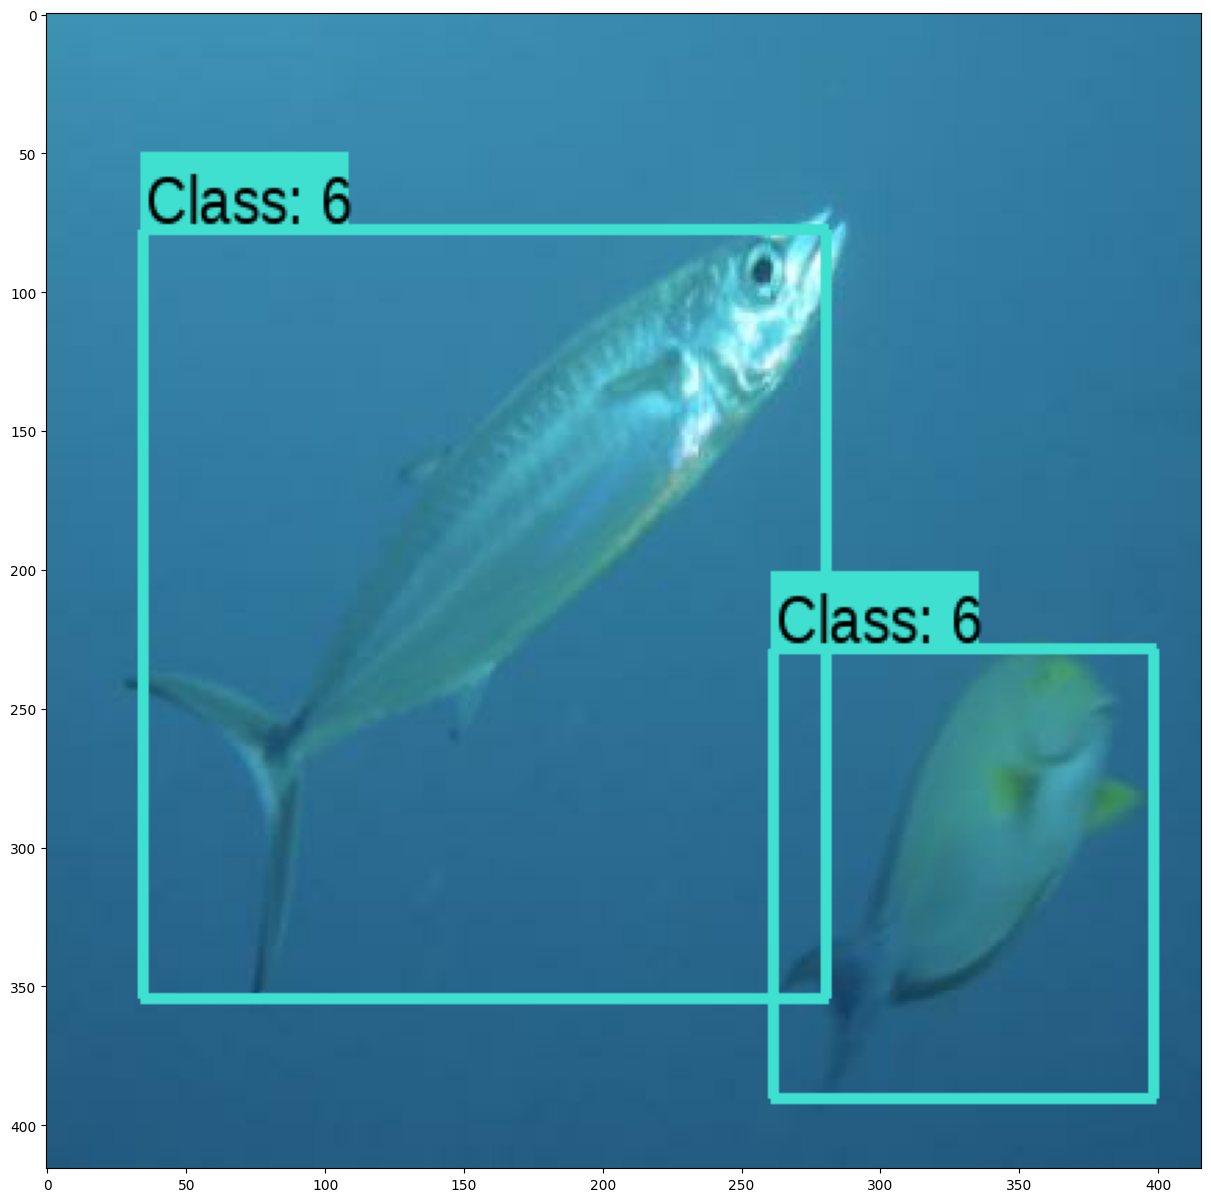

In [26]:
def detect_and_classify_fish(image_path, detector, classification_model, threshold=0.5):
    # Load the image
    img = load_img(image_path)

    # Run object detection
    converted_img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    result = detector(converted_img)

    # Get fish boxes
    fish_boxes = resort_fish_boxes(
        result["detection_boxes"],
        result["detection_class_entities"],
        result["detection_scores"],
        threshold=threshold
    )

    if fish_boxes is None:
        print("No fish detected.")
        return

    # Initialize an array to store the results
    array = []

    for coord in fish_boxes:
        # Extract coordinates
        ymin, xmin, ymax, xmax = coord

        # Crop the image
        cropped_img = img[int(ymin * img.shape[0]):int(ymax * img.shape[0]),
                          int(xmin * img.shape[1]):int(xmax * img.shape[1])]

        # Resize and preprocess the cropped image for classification
        img_np = np.array([cv2.resize(cropped_img.numpy(), (171, 138))])
        prediction = classification_model.predict(img_np, verbose=0)

        # Get the predicted class index
        predicted_class = np.argmax(prediction)

        # Append results to the array
        array.append([image_path, ymin, xmin, ymax, xmax, predicted_class])
        
    image_with_boxes = draw_boxes(
      img.numpy(), fish_boxes,
      np.array(array)[:,-1])
    
    display_image(image_with_boxes)

    # Convert the results to a DataFrame
    df_pred = pd.DataFrame(array, columns=['image', 'ymin', 'xmin', 'ymax', 'xmax', 'class'])

    return df_pred

# Example usage:
image_path = 'data/train/' + df_train['filename'][1]
df_results = detect_and_classify_fish(image_path, detector, model_mobilenetV2)
print(df_results)